In [2]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import metrics
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.datasets import mnist
from sklearn.model_selection import KFold
from tensorflow.python.keras import backend as K
from keras import optimizers
from sklearn.svm import SVC
from keras.layers import BatchNormalization
import csv

# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

# Import Support Vector Classifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from keras.wrappers.scikit_learn import KerasRegressor

from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR

from sklearn.linear_model import LogisticRegression


def load_data(filename, skiprows = 1):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    
    Inputs:
        filename: given as a string.
        
    Outputs:
        Data contained in the file, returned as a numpy ndarray
    """
    return np.loadtxt(filename, skiprows=skiprows, delimiter=',')

Using TensorFlow backend.


In [3]:
oversample = False
undersample = True
delete_useless_columns = True
top_k_features = False

grid_search = False

In [4]:
# load training data
training_data = load_data('train_2008.csv', 1)
np.random.shuffle(training_data)
# load testing data
test_data_08 = load_data('test_2008.csv', 1)
test_data_12 = load_data('test_2012.csv', 1)

In [5]:
if (oversample or undersample):
    # oversample the ones and undersample the zeros
    nonvoters = training_data[np.where(training_data[:,-1] == 0)]
    voters = training_data[np.where(training_data[:,-1] == 1)]
    nonvoters_indices = np.random.choice(len(nonvoters), len(voters) * 2)

    print(len(voters))
    print(len(nonvoters))

    if oversample:
        voters = np.concatenate((voters, voters), axis=0)
    if undersample:
        nonvoters = nonvoters[nonvoters_indices]

    # recompile the training data
    training_data = np.concatenate((voters, nonvoters), axis=0)
    print(len(training_data), " total data points, ", len(voters), " voter entries, and ", len(nonvoters), " nonvoter entries.")
    np.random.shuffle(training_data)

16515
48152
49545  total data points,  16515  voter entries, and  33030  nonvoter entries.


In [6]:
# get all of the parameters
train_data = training_data[:,:-1]
# get all the targets
train_target = training_data[:, -1]

In [6]:
# find any column which contains only one value in all its rows (such as interview month/year)
if delete_useless_columns:
    useless_columns = np.all(train_data == train_data[0,:], axis=0)
    indices_to_remove = []
    for i in range(len(useless_columns)):
        if useless_columns[i]:
            indices_to_remove.append(i)

    #delete those columns
    train_data = np.delete(train_data, indices_to_remove, 1)
    test_data_08 = np.delete(test_data_08, indices_to_remove, 1)
    test_data_12 = np.delete(test_data_12, indices_to_remove, 1)

In [ ]:
# get top k features
if (top_k_features):
    num_params = 15
    test = SelectKBest(k=num_params)
    fit = test.fit(train_data, train_target)

    scores = fit.scores_.tolist()
    scores_copy = fit.scores_.tolist()
    best_scores = []
    best_indices = []

    for i in range(num_params):
        m = max(scores)
        best_scores.append(m)
        best_indices.append(scores_copy.index(m))
        scores.remove(m)
        
    train_data = train_data[:, best_indices]
    test_data_08 = test_data_08[:, best_indices]
    test_data_12 = test_data_12[:, best_indices]

In [7]:
# split the data into train and test
X_train, X_test = train_data[0: len(train_data) * 9//10], train_data[len(train_data) * 9//10:]
y_train, y_test = train_target[0: len(train_data) * 9//10], train_target[len(train_data) * 9//10:]

In [ ]:
def neural_net_model():
    model = Sequential()
    model.add(Dense(1000, input_shape=(len(train_data[0]),), kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(480))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    
    model.compile(loss="binary_crossentropy", optimizer='adam')    
    return model

In [ ]:
if grid_search:
    nn_estimator = KerasRegressor(build_fn= neural_net_model)
    
    for batch_size in range(10, 100, 10):
        for epochs in range(3, 15, 3):
            nn_clf = KerasRegressor(build_fn= neural_net_model, epochs=epochs, batch_size=batch_size)
            nn_history = nn_clf.fit(X_train, y_train)
            nn_pred = nn_clf.predict(X_test)
            
            nn_false_pos_rate, nn_true_pos_rate, nn_thresholds = metrics.roc_curve(y_test, nn_pred, pos_label=1)
            print("nn with batch_size: ", batch_size, " and epochs: ", epochs, " gets ", metrics.auc(nn_false_pos_rate, nn_true_pos_rate))
            nn_auc = metrics.roc_auc_score(y_test, nn_pred)
            plt.plot(nn_false_pos_rate,nn_true_pos_rate,label="nn, auc="+str(nn_auc))
            plt.legend(loc=4)
            plt.show()

In [ ]:
def ensemble(preds, weights):
    assert len(preds) == len(weights)
    ensembled_preds = np.average(preds, weights=weights, axis=0)
    return ensembled_preds

In [ ]:
max_auc = 0
for max_depth in range(4,20,2):
    for n_estimators in range(10,150,10):
        tree_clf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)
        tree_history = tree_clf.fit(X_train, y_train)
        tree_pred = tree_clf.predict(X_test)

        tree_false_pos_rate, tree_true_pos_rate, tree_thresholds = metrics.roc_curve(y_test, tree_pred, pos_label=1)
        print("tree with max_depth: ", max_depth, " and n_estimators: ", n_estimators, " gets ", metrics.auc(tree_false_pos_rate, tree_true_pos_rate))
        tree_auc = metrics.roc_auc_score(y_test, tree_pred)
    
plt.plot(tree_false_pos_rate,tree_true_pos_rate,label="tree, auc="+str(tree_auc))
plt.legend(loc=4)
plt.show()

tree with max_depth:  4  and n_estimators:  10  gets  0.72940183202737
tree with max_depth:  4  and n_estimators:  20  gets  0.7322123202001252
tree with max_depth:  4  and n_estimators:  30  gets  0.7322970238752162
tree with max_depth:  4  and n_estimators:  40  gets  0.731142993782879
tree with max_depth:  4  and n_estimators:  50  gets  0.7311666298789684
tree with max_depth:  4  and n_estimators:  60  gets  0.7326231468197034
tree with max_depth:  4  and n_estimators:  70  gets  0.7313990361623073
tree with max_depth:  4  and n_estimators:  80  gets  0.733895909207961
tree with max_depth:  4  and n_estimators:  90  gets  0.7326660044880993


Epoch 1/10
52848/52848 [==============================] - 6s 107us/step - loss: 0.5975
Epoch 2/10
52848/52848 [==============================] - 5s 91us/step - loss: 0.5911
Epoch 3/10
52848/52848 [==============================] - 5s 92us/step - loss: 0.5901
Epoch 4/10
52848/52848 [==============================] - 5s 86us/step - loss: 0.5888
Epoch 5/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5884
Epoch 6/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5881
Epoch 7/10
52848/52848 [==============================] - 4s 83us/step - loss: 0.5867
Epoch 8/10
52848/52848 [==============================] - 5s 93us/step - loss: 0.5872
Epoch 9/10
52848/52848 [==============================] - 4s 85us/step - loss: 0.5864
Epoch 10/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5869


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ensemble  0.7730516382693141


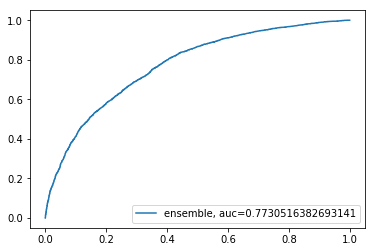

nn  0.7542083054178278


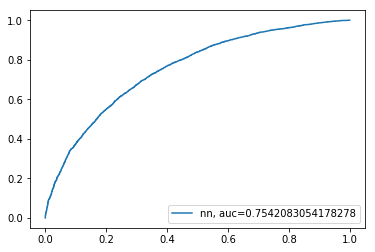

knn  0.7553480211439503


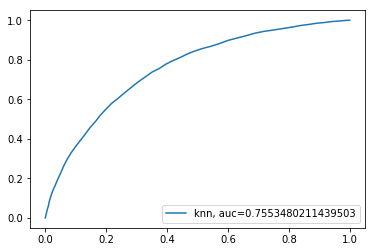

tree  0.7700334294002543


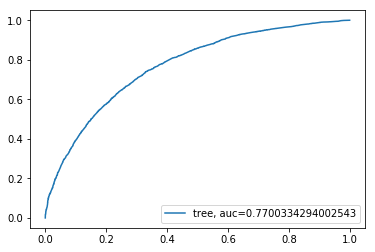

svr  0.7694321365162862


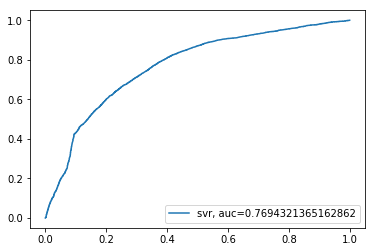

lr  0.6870048597499645


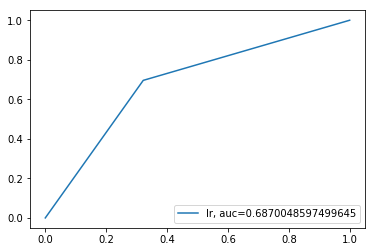

Epoch 1/10
52848/52848 [==============================] - 6s 111us/step - loss: 0.5957
Epoch 2/10
52848/52848 [==============================] - 5s 88us/step - loss: 0.5910
Epoch 3/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5892
Epoch 4/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5891
Epoch 5/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5881
Epoch 6/10
52848/52848 [==============================] - 5s 87us/step - loss: 0.5878
Epoch 7/10
52848/52848 [==============================] - 5s 91us/step - loss: 0.5869
Epoch 8/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5866
Epoch 9/10
52848/52848 [==============================] - 5s 91us/step - loss: 0.5865
Epoch 10/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5858


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ensemble  0.7757365847409746


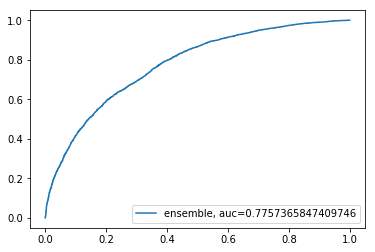

nn  0.7608856581972727


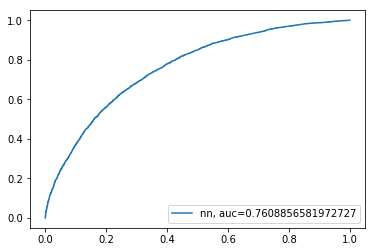

knn  0.7559474527939879


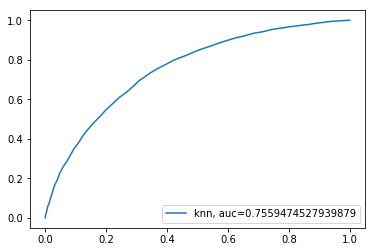

tree  0.7679750876048392


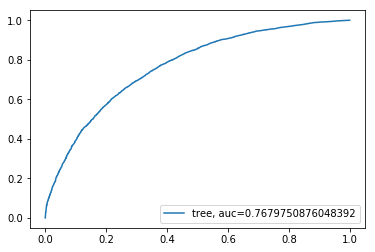

svr  0.770569529133228


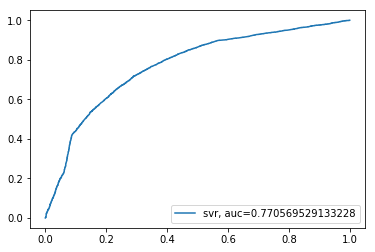

lr  0.68878928468184


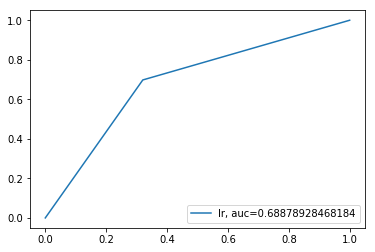

Epoch 1/10
52848/52848 [==============================] - 6s 111us/step - loss: 0.5945
Epoch 2/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5895
Epoch 3/10
52848/52848 [==============================] - 5s 88us/step - loss: 0.5875
Epoch 4/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5865
Epoch 5/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5864
Epoch 6/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5860
Epoch 7/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5853
Epoch 8/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5852
Epoch 9/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5846
Epoch 10/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5847


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ensemble  0.7673457668191492


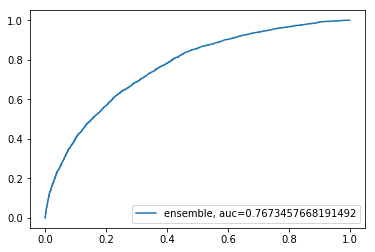

nn  0.7519594054613002


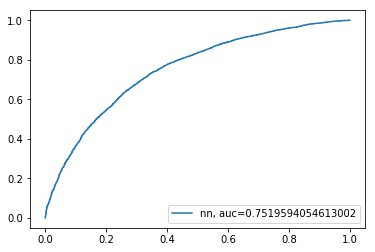

knn  0.7470633007839913


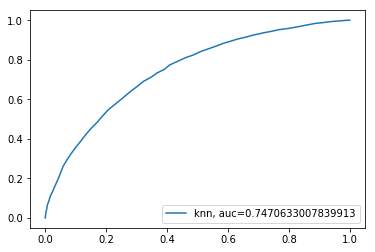

tree  0.7606721186098404


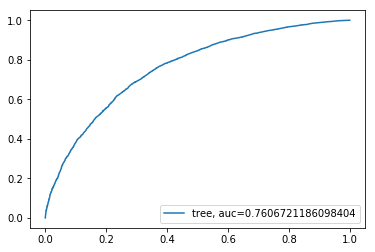

svr  0.7627189289366418


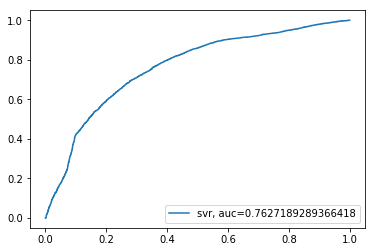

lr  0.6855427185050027


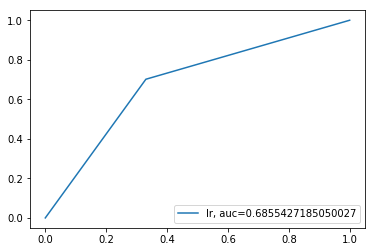

Epoch 1/10
52848/52848 [==============================] - 6s 115us/step - loss: 0.5937
Epoch 2/10
52848/52848 [==============================] - 5s 89us/step - loss: 0.5899
Epoch 3/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5885
Epoch 4/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5879
Epoch 5/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5862
Epoch 6/10
52848/52848 [==============================] - 5s 88us/step - loss: 0.5866
Epoch 7/10
52848/52848 [==============================] - 5s 92us/step - loss: 0.5860
Epoch 8/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5849
Epoch 9/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5854
Epoch 10/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5853


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ensemble  0.7677810815835191


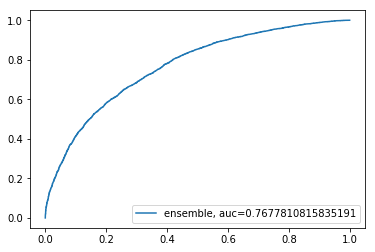

nn  0.7527473726203981


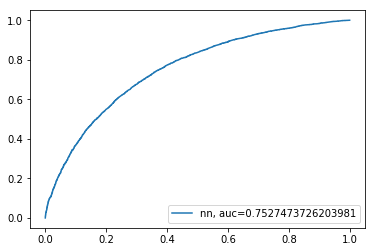

knn  0.7472274989714884


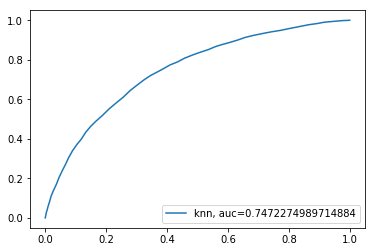

tree  0.762883677447766


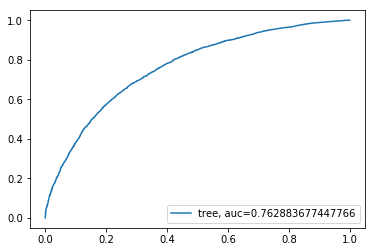

svr  0.7657424263230032


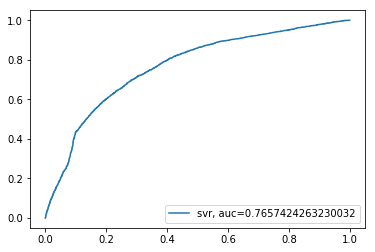

lr  0.6817049972096353


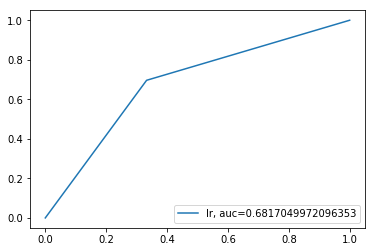

Epoch 1/10
52848/52848 [==============================] - 6s 116us/step - loss: 0.5955
Epoch 2/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5906
Epoch 3/10
52848/52848 [==============================] - 5s 91us/step - loss: 0.5890
Epoch 4/10
52848/52848 [==============================] - 5s 90us/step - loss: 0.5883
Epoch 5/10
52848/52848 [==============================] - 5s 92us/step - loss: 0.5874
Epoch 6/10
52848/52848 [==============================] - 4s 85us/step - loss: 0.5870
Epoch 7/10
52848/52848 [==============================] - 5s 92us/step - loss: 0.5862
Epoch 8/10
52848/52848 [==============================] - 5s 91us/step - loss: 0.5857
Epoch 9/10
52848/52848 [==============================] - 5s 91us/step - loss: 0.5863
Epoch 10/10
52848/52848 [==============================] - 5s 91us/step - loss: 0.5855


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ensemble  0.7730904694287289


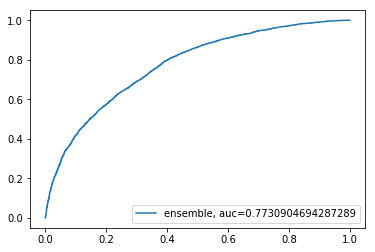

nn  0.7552763513587215


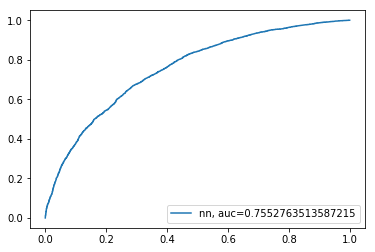

knn  0.7541015626969344


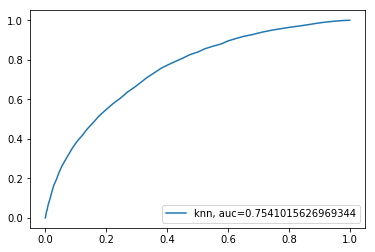

tree  0.7669921212047326


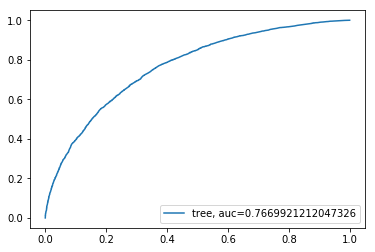

svr  0.7696900331631165


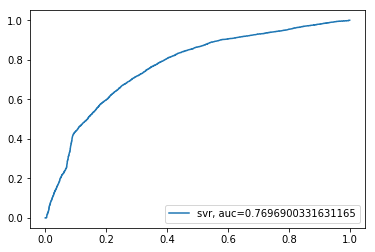

lr  0.6866067630244682


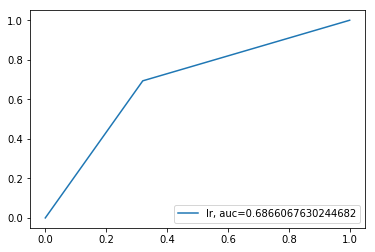

In [8]:
# 5-fold validation
kf = KFold(n_splits=5)
ensembles = []
models = []
weights = []

for train_index, test_index in kf.split(train_data):
    X_train, y_train = train_data[train_index], train_target[train_index]
    X_test, y_test = train_data[test_index], train_target[test_index]
    
    nonvoters = training_data[np.where(training_data[:,-1] == 0)]
    voters = training_data[np.where(training_data[:,-1] == 1)]
        
#     clf = SVC(gamma='auto')
#     clf.fit(X_train, y_train) 
    
#     pred = clf.predict_proba(X_test)[:,1]
    
    #--------------------------------------------
    
#     nn_estimator = KerasRegressor(build_fn= neural_net_model, epochs=3, batch_size=150)
    
#     boosted_nn = AdaBoostRegressor(base_estimator = nn_estimator)
#     model = boosted_nn.fit(X_train, y_train)
#     pred = boosted_nn.predict(X_test)
    
    #--------------------------------------------
    
#     svc=SVC(probability=True, kernel='linear')

#     # Create adaboost classifer object
#     abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

#     # Train Adaboost Classifer
#     model = abc.fit(X_train, y_train)

#     #Predict the response for test dataset
#     pred = model.predict(X_test)


#     # Model Accuracy, how often is the classifier correct?
#     print("Accuracy:",metrics.accuracy_score(y_test, pred))

#     # --------------------------------------------
        

  #     # --------------------------------------------
      
        
    nn_clf = KerasRegressor(build_fn= neural_net_model, epochs=3, batch_size=50)
    knn_clf = KNeighborsRegressor(n_neighbors=60)
    tree_clf = RandomForestRegressor(max_depth=8)
    svr_clf = SVR()
    lr_clf = LogisticRegression()
    
    nn_history = nn_clf.fit(X_train, y_train, epochs=10, batch_size=150)
    knn_history = knn_clf.fit(X_train, y_train)
    tree_history = tree_clf.fit(X_train, y_train)
    svr_history = svr_clf.fit(X_train, y_train)
    lr_history = lr_clf.fit(X_train, y_train)

    nn_pred = nn_clf.predict(X_test)
    knn_pred = knn_clf.predict(X_test)
    tree_pred = tree_clf.predict(X_test)
    svr_pred = svr_clf.predict(X_test)
    lr_pred = lr_clf.predict(X_test)

    ensemble_pred = ensemble([nn_pred, knn_pred, tree_pred, svr_pred, lr_pred], [1, 1, 1, 1, 1])
    ensembles.append(tree_pred)
    
    models.append(nn_clf)
    weights.append(1)
    models.append(knn_clf)
    weights.append(1)
    models.append(tree_clf)
    weights.append(1)
    models.append(svr_clf)
    weights.append(1)
    models.append(lr_clf)
    weights.append(1)
    
#     #--------------------------------------------
    
    ## Printing a summary of the layers and weights in your model
#     model.summary()

#     model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

#     fit = model.fit(np.array(X_train), np.array(y_train), batch_size=150, nb_epoch=10,
#        verbose=1)

#     ## Printing the accuracy of our model, according to the loss function specified in model.compile above
#     score = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
#     print('Test score:', score[0])
#     print('Test accuracy:', score[1])

#     test.fit(X_train, y_train)
    
#     pred = model.predict_proba(X_test)[:,1]
#     #--------------------------------------------

    e_false_pos_rate, e_true_pos_rate, e_thresholds = metrics.roc_curve(y_test, ensemble_pred, pos_label=1)
    print("ensemble ", metrics.auc(e_false_pos_rate, e_true_pos_rate))
    e_auc = metrics.roc_auc_score(y_test, ensemble_pred)
    plt.plot(e_false_pos_rate,e_true_pos_rate,label="ensemble, auc="+str(e_auc))
    plt.legend(loc=4)
    plt.show()

    nn_false_pos_rate, nn_true_pos_rate, nn_thresholds = metrics.roc_curve(y_test, nn_pred, pos_label=1)
    print("nn ", metrics.auc(nn_false_pos_rate, nn_true_pos_rate))
    nn_auc = metrics.roc_auc_score(y_test, nn_pred)
    plt.plot(nn_false_pos_rate,nn_true_pos_rate,label="nn, auc="+str(nn_auc))
    plt.legend(loc=4)
    plt.show()
    
    knn_false_pos_rate, knn_true_pos_rate, knn_thresholds = metrics.roc_curve(y_test, knn_pred, pos_label=1)
    print("knn ", metrics.auc(knn_false_pos_rate, knn_true_pos_rate))
    knn_auc = metrics.roc_auc_score(y_test, knn_pred)
    plt.plot(knn_false_pos_rate,knn_true_pos_rate,label="knn, auc="+str(knn_auc))
    plt.legend(loc=4)
    plt.show()
    
    tree_false_pos_rate, tree_true_pos_rate, tree_thresholds = metrics.roc_curve(y_test, tree_pred, pos_label=1)
    print("tree ", metrics.auc(tree_false_pos_rate, tree_true_pos_rate))
    tree_auc = metrics.roc_auc_score(y_test, tree_pred)
    plt.plot(tree_false_pos_rate,tree_true_pos_rate,label="tree, auc="+str(tree_auc))
    plt.legend(loc=4)
    plt.show()
    
    svr_false_pos_rate, svr_true_pos_rate, svr_thresholds = metrics.roc_curve(y_test, svr_pred, pos_label=1)
    print("svr ", metrics.auc(svr_false_pos_rate, svr_true_pos_rate))
    svr_auc = metrics.roc_auc_score(y_test, svr_pred)
    plt.plot(svr_false_pos_rate,svr_true_pos_rate,label="svr, auc="+str(svr_auc))
    plt.legend(loc=4)
    plt.show()
    
    lr_false_pos_rate, lr_true_pos_rate, lr_thresholds = metrics.roc_curve(y_test, lr_pred, pos_label=1)
    print("lr ", metrics.auc(lr_false_pos_rate, lr_true_pos_rate))
    lr_auc = metrics.roc_auc_score(y_test, lr_pred)
    plt.plot(lr_false_pos_rate,lr_true_pos_rate,label="lr, auc="+str(lr_auc))
    plt.legend(loc=4)
    plt.show()
    

In [9]:
def test_predictions(test_data, models, weights):
    preds = []
    for i in range(len(models)):
        pred = models[i].predict(test_data)
        preds.append(pred)
    return ensemble(preds, weights)        

In [10]:
def new_test_predictions(train_data, models, weights):
    nn_pred = nn_clf.predict(train_data)
    knn_pred = knn_clf.predict(train_data)
    tree_pred = tree_clf.predict(train_data)
    svr_pred = svr_clf.predict(train_data)
    lr_pred = lr_clf.predict(train_data)
    ensemble_pred = ensemble([nn_pred, knn_pred, tree_pred, svr_pred, lr_pred], [1,1,1,1,1])

    return ensemble_pred

In [11]:
final = new_test_predictions(train_data, models, weights)
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(train_target, final, pos_label=1)
print(metrics.auc(false_pos_rate, true_pos_rate))

0.7897665619077291


In [12]:
# 2008 predictions
predictions = test_predictions(test_data_08, models, weights).flatten()
with open('test_2008_predictions.csv', mode='w') as test_2008_predictions:
    prediction_writer = csv.writer(test_2008_predictions, delimiter=',')
    prediction_writer.writerow(['id', 'target'])
    for row in range(len(predictions)):
        prediction_writer.writerow([row, predictions[row]])

In [ ]:
# 2012 predictions
predictions = test_predictions(test_data_12, models, weights).flatten()
with open('test_2012_predictions.csv', mode='w') as test_2012_predictions:
    prediction_writer = csv.writer(test_2012_predictions, delimiter=',')
    prediction_writer.writerow(['id', 'target'])
    for row in range(len(predictions)):
        prediction_writer.writerow([row, predictions[row]])